# Introduction
<p>
This notebook is a very basic and simple introductory primer to the method of ensembling(combining) base learning models, inparticular the varient of ensembling known as Stacking. In a nutshell stacking uses a first-level(base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions.
</p>
<p>
The Titanic dataset is a prime candidate for introducing this concept as many newcomers to Kaggle start out here. Futhermore even though stacking has been responsible for many a team winning Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill somewhat of that void.
</p>
<p>
I myself am quite a newcomer to the Kaggle scene as well the first proper ensembling/stacking script that I managed to change upon and study was one written in the AllState Severity Claims competition by the great Faron. The material in this notebook borrows heavily from Faron's script although ported to factor in ensembles of classifiers whilst his was ensembles of regressors.
</p>
<p>
Anyway please check out his script here:
</p>
<p>
Stacking Starter: by Faron
</p>
<p>
Now onto the notebook at hand and I hope that it manages to do justice and convey the concept of ensembling in an intuitive and concise manner. My other standalone Kaggle script which implements exactly the same ensembling steps(albeit with different parameters)discussed below gives a Public LB score of 0.808 which is good enough to get to the top 9% and runs just under 4 minutes. Therefore I am pretty sure there is a lot of room to improve and add on to that script. Anyway please feel free to leave me any comments with regards to how I can improve.
</p>

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

C:\Users\CUCHO\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\CUCHO\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\CUCHO\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Feature Exploration, Engineering and Cleaning
Now we will proceed much like how most kernels in general are structured, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [2]:
# Load in the train and test dataset
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Store our passenger ID for easy access
PassengerID = test['PassengerId']

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Well it is no surprise that our task is to somehow extract the information out of the categorical variables.

## Feature Engineering 
Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work.<br>


[Titanic Best Working Classifier](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier): by Sina


In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name 
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic 
train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x:0 if type(x)==float else 1)

# Feature engineer steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New Feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std,
                                            age_avg + age_std,
                                            size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define function to extract title from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it. 
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data: 
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jokheer', 'Dona'])
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)
    
    # Mapping Title 
    title_mapping = {'Mr':1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    
    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <=31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    
    # Mapping Age
    dataset.loc[dataset['Age'] <= 15, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4;

In [4]:
# Feature selection 
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho

### Visualizations

In [5]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0.0,0,23,0,2,0,1.0
1,1,1,0,2,0,3.0,1,51,1,2,0,3.0
2,1,3,0,1,0,1.0,0,22,0,1,1,2.0
3,1,1,0,2,0,3.0,0,44,1,2,0,3.0
4,0,3,1,2,0,1.0,0,24,0,1,1,1.0


### Pearson Correlation Heatmap
Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

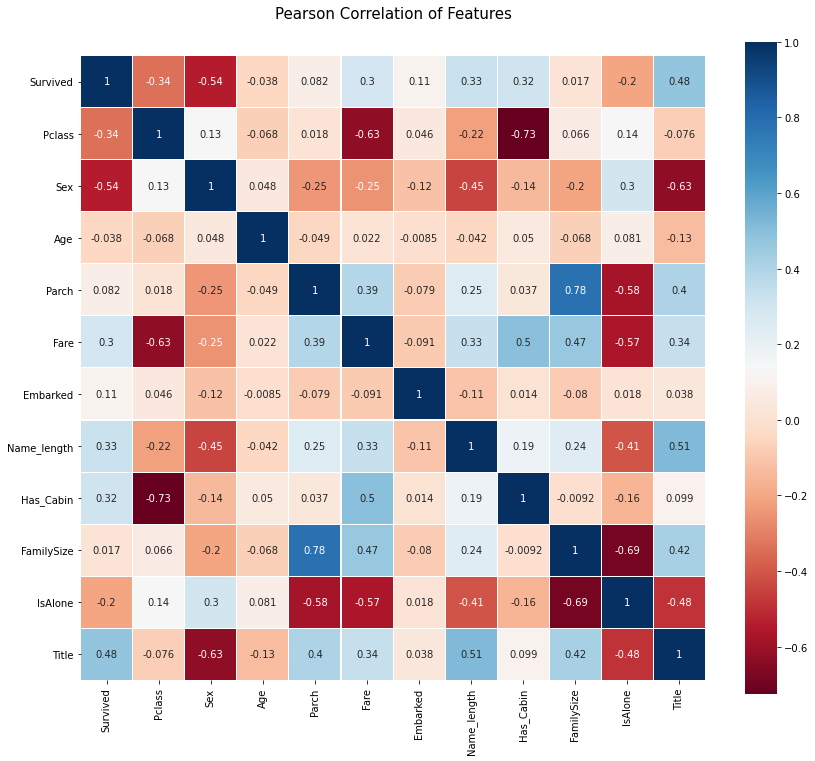

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True)

### Takeaway from the Plots
One thing that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. 
Here are two most correlated features are that of Family size and Parch(Parents and Children). I'll still leave both features in for the purposes of this exercise.<br>

### Pairplots
Finally let us generate some pairplots to observe the distribution of data from on feature to the other. Once again we use Seaborn to help us. 

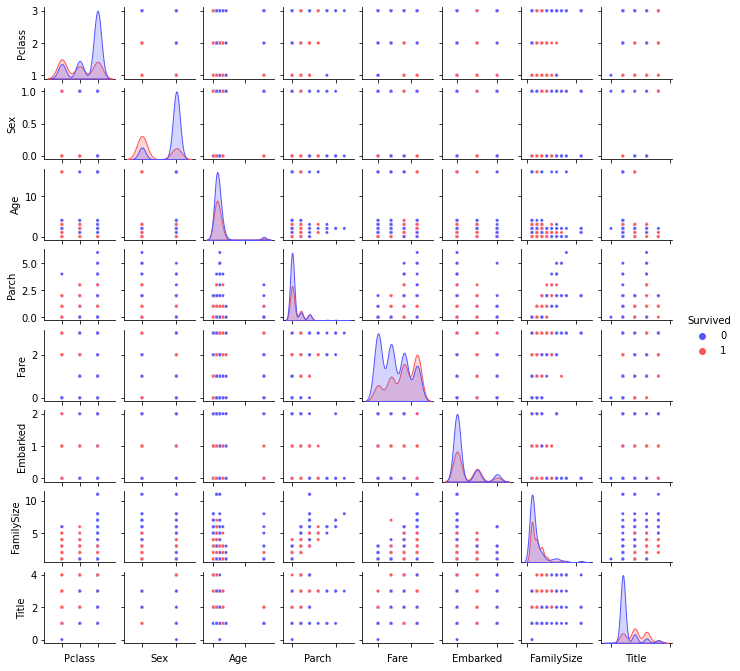

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare',
                       u'Embarked', u'FamilySize', u'Title']], hue='Survived', 
                 palette='seismic',
                size=1.2, diag_kind='kde', diag_kws=dict(shade=True), 
                 plot_kws=dict(s=10))
g.set(xticklabels=[])

## Ensembling & Stacking models
Finally after that brief whirlwind detout with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook. <br>

Creating a Stacking ensemble!

### Helpers via Python Classes
Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Objects Oriented Programming(OOP). In short, a class helps to extend some code/program for creating objects(variables for old-school peeps) as well as to implement functions and methods specific to that class.<br>

In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods(such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [8]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0# for repruducibility 
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED) # ntrain 여부, n_split 여부로 에러 발생

# Class to extend the Sklearn classifier 
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)
        
# Class to extend XGBoost classifier

Bear with me for those who already know this but for people who have not created classes of objects in Python before, let me explain what the code given above does. In creating my base classifiers, I will only use the models already present in the Sklearn library and therefore only extend the class for that. <br>

**def init**: Python standard for invoking the default constructor for the class. This means that when you want to create an object(classifier), you have to give it the parameters of clf(what sklearn classifier you want), seed(random seed) and params(parameters for the classifiers). <br>

The rest of the code are simply method of the class which simply call the corresponding methods already existing within the sklearn classifiers. Essentially, we have created a wrapper class to extend the various Sklearn classifiers so that this should help us reduce having to write the same code over and over when we implement multiple learners to our stacker.

## Out-of-Fold Predictions
Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simpy train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having 'seen' the test set and therefore overfitting when feeding these predictions.

In [9]:
def get_ddf(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_test[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-level Models 
So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:<br>

1. Random Forest classifier
2. Extra Trees classifier 
3. AdaBoost classifier
4. Gradient Boosting classifier
5. Support Vector Machine


### Parameters
Just a quick summary of the parameters that we will be listing here for completeness, <br>

**n_jobs**: Number of cores used for the training process. If set to -1, all cores are used. <br>

**n_estimators**: Number of classification trees in your learning model(set to 10 per default)<br>

**max_depth**: Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as on would be growing the tree too deep<br>

Please check out the full description via official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with.


In [10]:
# Put in our parameters for said classifiers

# Random Forest parameters
rf_params = {
    'n_jobs': -1, 
    'n_estimators': 500,
    'warm_start' : True,
    # 'max_feature' : 0.2
    'max_depth' : 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose' : 0    
}

# Extra Trees Parameters
et_params = {
    'n_jobs' : -1,
    'n_estimators':500,
    # 'max_features' : 0.5,
    'max_depth' : 8,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators':500,
    'learning_rate':0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    # 'max_features' : 0.2,
    'max_depth' : 5,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

# Support Vector Classifier parameters
svm_params = {
    'kernel' : 'linear',
    'C' : 0.25
}

Futhermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [11]:
# Create 5 objects that represent our 4models
rf = S

NameError: name 'S' is not defined